# Road segmentation

We aim in this project to train a classifier to segment roads in satellite images. We have a set of satellite images and their corresponding ground truth labels.
First, we will use a logistic regression model to classify each pixel as road or background. In a second part, we will use a convolutional neural network to do the same task.


In [1]:
import os, sys
import numpy as np
from PIL import Image
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Import additional modules
from plot import *
from helper import *
from mask_to_submission import *


# Model 1 : Logistic Regression


In [3]:
# Import modules for logistic regression
import sklearn
from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


### 1. Load the images

In [4]:
# Set the root directory
root_dir = "training/"

# Set the image directory
image_dir = root_dir + "images/"

# Set the groundtruth directory
gt_dir = root_dir + "groundtruth/"


Note : The function load_image() normalize the values of the images to be between 0 and 1.


In [5]:
# Get the number of images
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")

# Load the images and normalize their values to be between 0 and 1
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print("First image file: " + files[0])
print("First image shape: " + str(imgs[0].shape))

# Load the groundtruth images
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print("First groundtruth file: " + files[0])
print("First groundtruth shape: " + str(gt_imgs[0].shape))

Loading 100 images
First image file: satImage_052.png
First image shape: (400, 400, 3)
First groundtruth file: satImage_052.png
First groundtruth shape: (400, 400)


Image size = 400,400


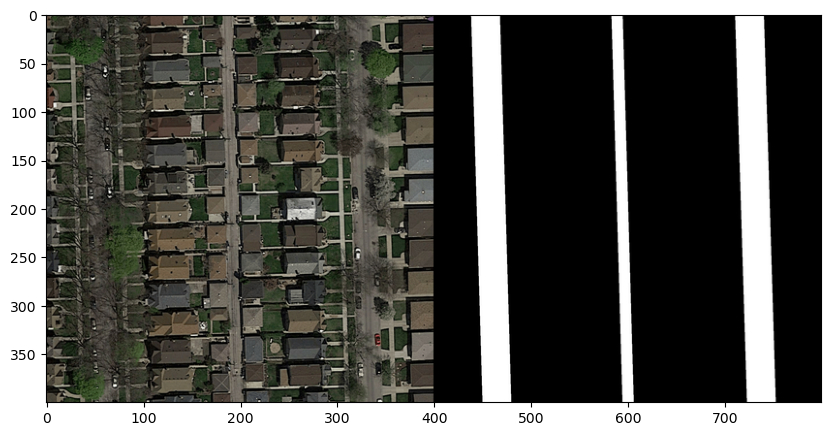

In [6]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))
# plt.cla()
# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")
plt.show()

### 2. Extract features

The first step consists in subdividing the images into smaller patches. We choose a patch size of 16x16 pixels. Given that the images are 400x400 pixels, this results in 256 patches per image.
The pixels values were normalized to be between 0 and 1 during the loading step, such that :
- a pixel value of 0 = black
- a pixel value of 1 = white
- a pixel value between 0 and 1 = grayscale intensities

Therefore, to extract labels from the groundtruth images, we define a threshold such that for a given patch of size 16x16 pixels, if the mean of the pixels values in that patch is greater than the threshold, the patch is considered as "foreground" (class 1) or "road". Otherwise, it's considered "background" (class 0).

Then, we extract 4 features from each patch by computing the mean, the variance, the average gradient magnitude and the average laplacian value for each patch.
We use the Sobel operator to compute the gradient magnitude and the Laplacian operator to compute the laplacian value. These features help detect roads by capturing :
- brigthness(mean), 
- local contrast(variance),
- edge strength(Sobel, Laplacian) which helps detect the edges of the roads.


In [7]:
# We define the size of the patches.
patch_size = 16  # each patch is 16*16 pixels


# Extract patches from input images
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]


# Linearize list of patches to create a 2D array (convert lists to numpy arrays)
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

In [8]:
# Extract features vector (mean and variance) for each image patch
X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])

# Create labels (0 for background, 1 for road) for each image patch
foreground_threshold = 0.25
# If the mean of the pixels values in a patch is greater than 0.25, that patch will be considered as "road" (class 1). 
# Otherwise, it's considered "background" (class 0)
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [9]:
# Print feature statistics

print("Computed " + str(X.shape[0]) + " features")
print("Feature dimension = " + str(X.shape[1]))
print("Number of classes = " + str(len(np.unique(Y))))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print("Class 0: " + str(len(Y0)) + " samples")
print("Class 1: " + str(len(Y1)) + " samples")

Computed 62500 features
Feature dimension = 4
Number of classes = 2
Class 0: 46309 samples
Class 1: 16191 samples


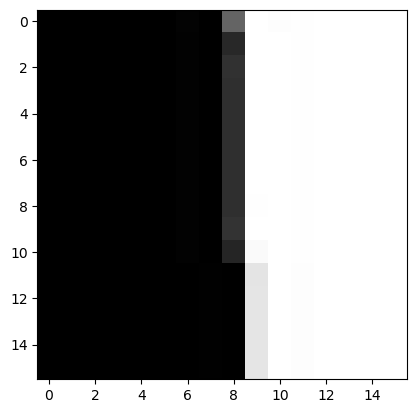

In [10]:
# Display a patch that belongs to the the "road" class
plt.imshow(gt_patches[Y1[4]], cmap="Greys_r")
plt.show()

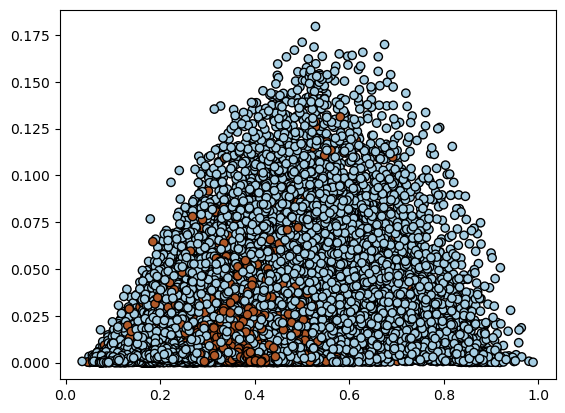

In [11]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)
plt.show()

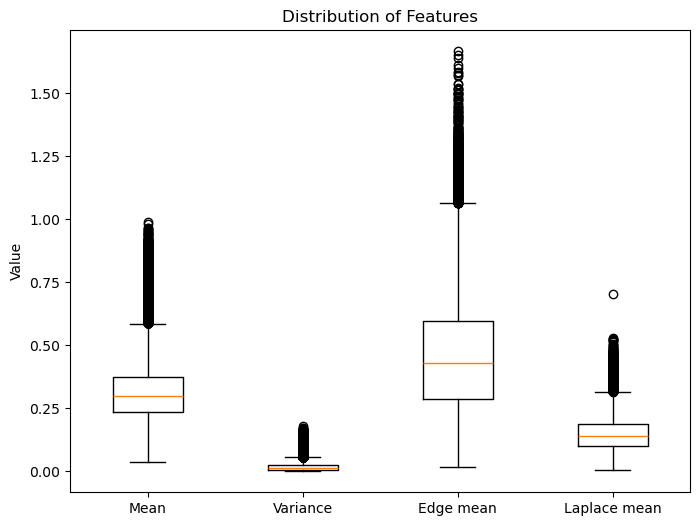

In [12]:
# Visualize the 2d features
plt.figure(figsize=(8, 6))
plt.boxplot(X, tick_labels=["Mean", "Variance", "Edge mean", "Laplace mean"])
plt.title('Distribution of Features')
plt.ylabel('Value')
plt.show()


The data presents a lot of outliers for both mean and variance features. We can set a threshold to remove them.


In [13]:
# Remove outliers using z-score
z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X_clean = X[filtered_entries]
Y_clean = Y[filtered_entries]

smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_clean, Y_clean)


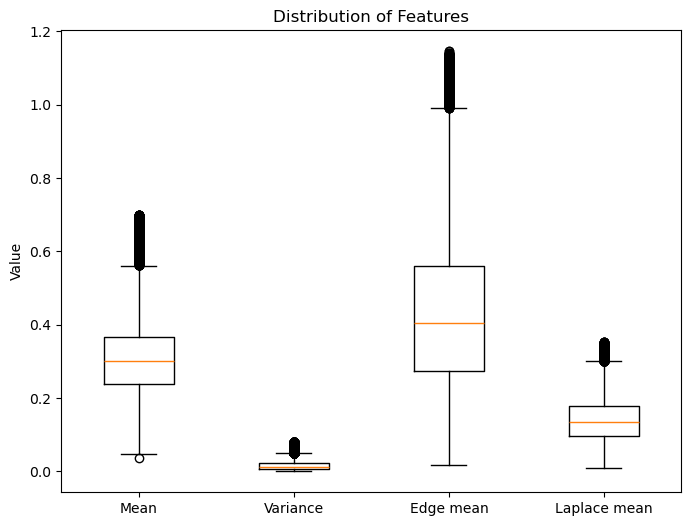

In [14]:
# Visualize the 2d features
plt.figure(figsize=(8, 6))
plt.boxplot(X_resampled, tick_labels=["Mean", "Variance", "Edge mean", "Laplace mean"])
plt.title('Distribution of Features')
plt.ylabel('Value')
plt.show()

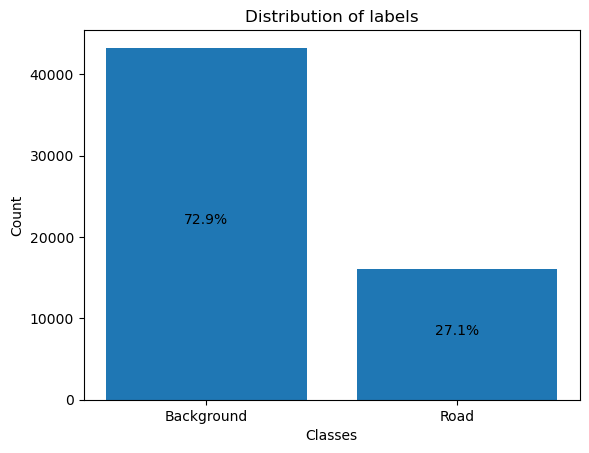

In [15]:
#Visualize distribution of labels
unique, counts = np.unique(Y_clean, return_counts=True)
plt.bar(["Background", "Road"], counts)
total = len(Y_clean)
percentages = counts / total * 100
plt.text(0, counts[0]/2, f'{percentages[0]:.1f}%', ha='center')
plt.text(1, counts[1]/2, f'{percentages[1]:.1f}%', ha='center')
plt.title("Distribution of labels")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

The data is imbalanced with 25.9% of the data belonging to the "road" class. We perform oversampling to balance the data using SMOTE.

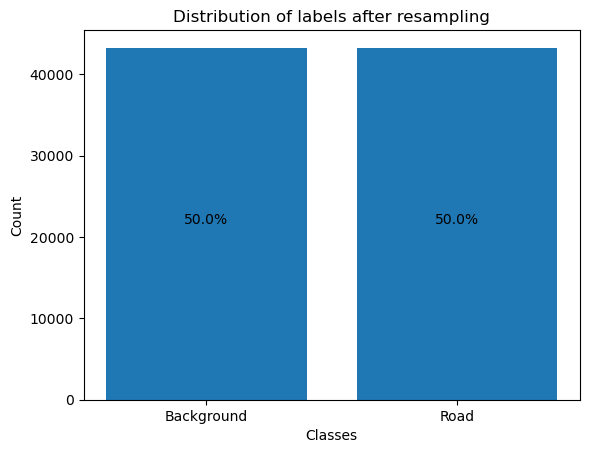

In [16]:
#Visualize distribution of labels
unique, counts = np.unique(Y_resampled, return_counts=True)
plt.bar(["Background", "Road"], counts)
total = len(Y_resampled)
percentages = counts / total * 100
plt.text(0, counts[0]/2, f'{percentages[0]:.1f}%', ha='center')
plt.text(1, counts[1]/2, f'{percentages[1]:.1f}%', ha='center')
plt.title("Distribution of labels after resampling")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

### 3. Train the model


#### 3.1. Split the data into training and testing sets


In [17]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)
print("Training set size: " + str(X_train.shape[0]))
print("Testing set size: " + str(X_test.shape[0]))


Training set size: 69192
Testing set size: 17298


#### 3.2. Train a simple logistic regression model

In [18]:
#Train the logistic regression model
logistic_model = linear_model.LogisticRegression()

#Fit the model
logistic_model.fit(X_train, Y_train)

# Compute the log loss of the model
Y_train_pred_proba = logistic_model.predict_proba(X_train)[:, 1]    
Y_test_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
log_loss_train = log_loss(Y_train, Y_train_pred_proba)
log_loss_test = log_loss(Y_test, Y_test_pred_proba)
print("The final training log loss is: " + str(round(log_loss_train, 2)))
print("The final test log loss is: " + str(round(log_loss_test, 2)))


The final training log loss is: 0.66
The final test log loss is: 0.66


#### 3.3. Evaluate the model


In [19]:
# Predict the labels of the testing set
Y_pred = logistic_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Display the confusion matrix
class_names = ["Background", "Road"]
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, Y_test, 
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=None).ax_.set_title("Confusion matrix")

# True positive
tp = conf_matrix[1, 1]
print("True positive: " + str(tp))  

# True negative
tn = conf_matrix[0, 0]
print("True negative: " + str(tn))

# False positive
fp = conf_matrix[0, 1]
print("False positive: " + str(fp))

# False negative
fn = conf_matrix[1, 0]
print("False negative: " + str(fn))

#Use the confusion matrix to compute the accuracy, precision, recall and f1-score of the model
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
#f1_score = 2 * precision * recall / (precision + recall)
f1_score = sklearn.metrics.f1_score(Y_test, Y_pred)
print("Accuracy: " + str(round(accuracy, 2)))
print("Precision: " + str(round(precision, 2)))
print("Recall: " + str(round(recall, 2)))
print("F1-score: " + str(round(f1_score, 2)))


True positive: 5076
True negative: 5525
False positive: 3126
False negative: 3571
Accuracy: 0.61
Precision: 0.62
Recall: 0.59
F1-score: 0.6


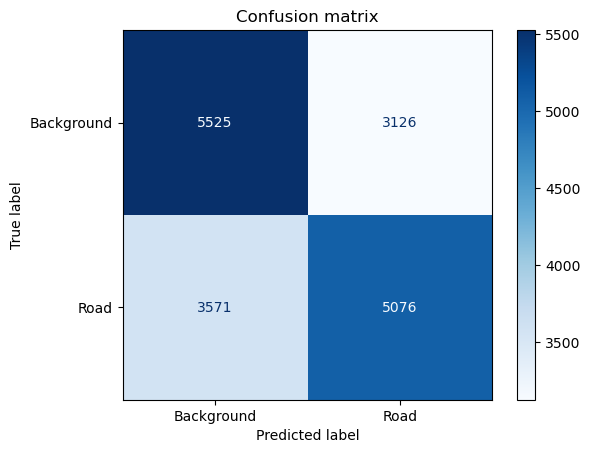

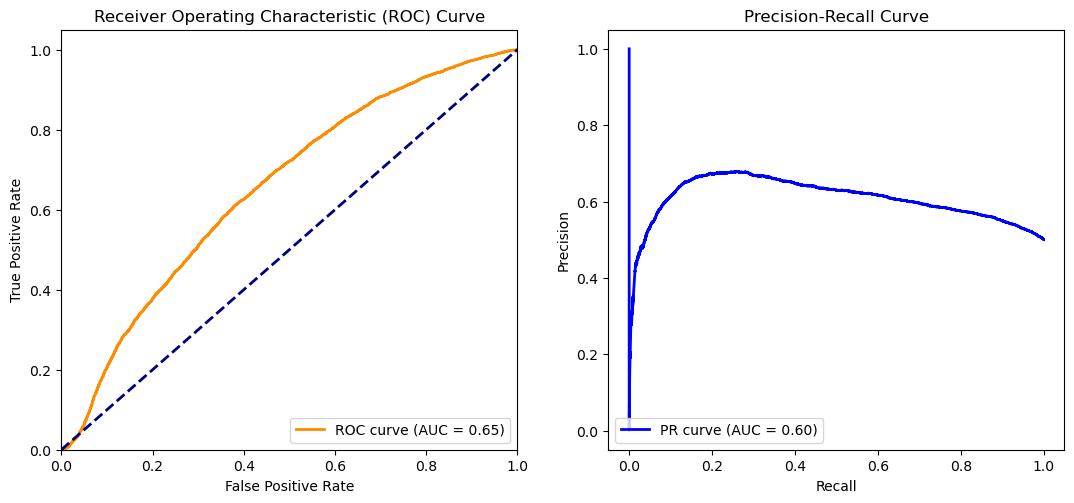

In [20]:
# Let's plot the AUC curve of the model.
plot_logistic_regression_evaluation(logistic_model, X_test, Y_test)
plt.show()


AUC = 1.0: Perfect model (100% correct predictions)
AUC = 0.5: Random model (like flipping a coin)
AUC < 0.5: Worse than random

We have an AUC of 0.63 for the ROC curve which means performs better than random, but still not very good.
This is confirmed by the precision-recall curve which has a AUC of 0.33, meaning that the model is not very good at predicting the "road" class.

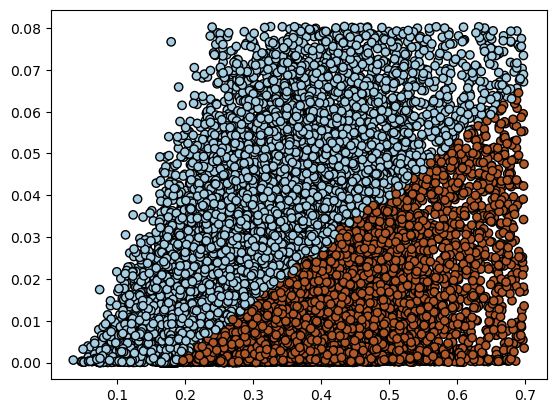

In [21]:
# Plot features using predictions to color datapoints
Y_train_pred = logistic_model.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train_pred, edgecolors="k", cmap=plt.cm.Paired)
plt.show()


The decision boundary is linear in the feature space, which might not capture the complexity of the data. We will try to improve the model by adding regularization.


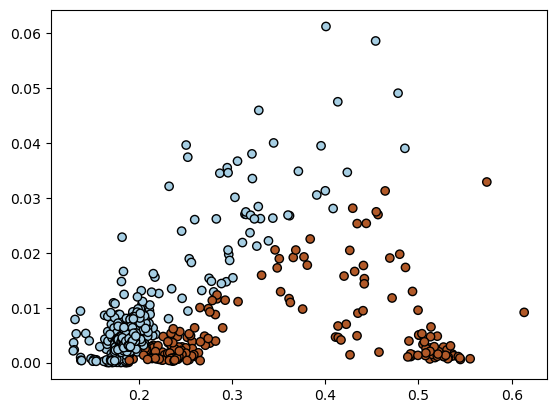

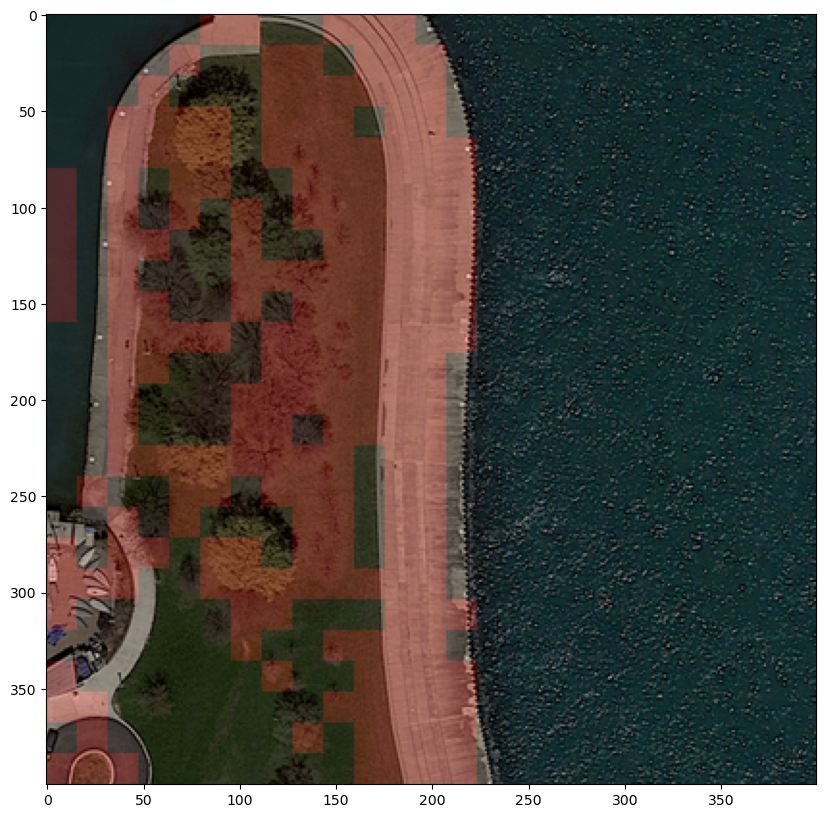

In [22]:
# Run prediction on the img_idx-th image
img_idx = 12
from helper import extract_img_features
Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = logistic_model.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors="k", cmap=plt.cm.Paired)

# Display prediction as an image
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
plt.show()

### 4. Train a logistic regression model with ridge regularization and cross-validation


In [23]:
#Train a regularized logistic regression with cross-validation (5 folds)
logistic_model_cv = linear_model.LogisticRegressionCV(penalty="l2", cv=5, Cs=[1e5, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

#Fit the model
logistic_model_cv.fit(X_train, Y_train)


LogisticRegressionCV(Cs=[100000.0, 10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01,
                         0.001, 0.0001, 1e-05],
                     cv=5)

In [24]:
# Calculate losses
train_loss = log_loss(Y_train, logistic_model_cv.predict_proba(X_train)[:, 1])
test_loss = log_loss(Y_test, logistic_model_cv.predict_proba(X_test)[:, 1])
print(f"Training log loss: {train_loss:.2f}")
print(f"Test log loss: {test_loss:.2f}")


Training log loss: 0.66
Test log loss: 0.66


Best C: [100000.]
Best lambda: [1.e-05]


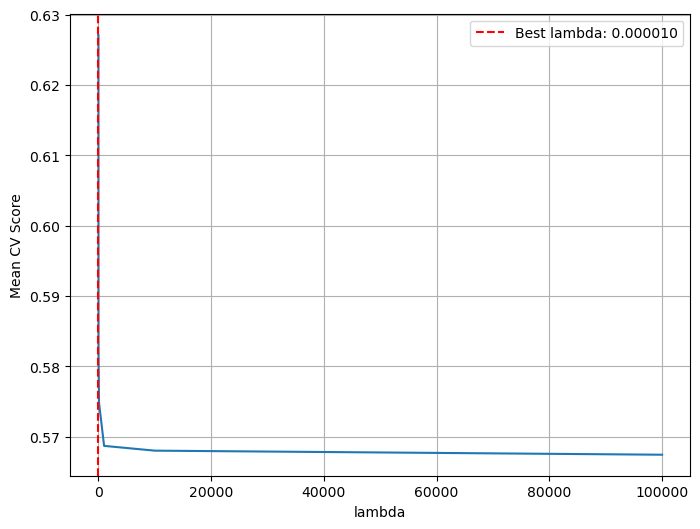

In [25]:
print(f"Best C: {logistic_model_cv.C_}")  # C is inverse of lambda
print(f"Best lambda: {1/logistic_model_cv.C_}")

# Get mean scores across folds for each C value
scores = logistic_model_cv.scores_[1]  # Get scores for feature 1
mean_scores = np.mean(scores, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(1/logistic_model_cv.Cs_, mean_scores)
plt.xlabel('lambda')
plt.ylabel('Mean CV Score')
plt.axvline(1/logistic_model_cv.C_[0], color='r', linestyle='--', label=f'Best lambda: {1/logistic_model_cv.C_[0]:.6f}')
plt.legend()
plt.grid(True)
plt.show()


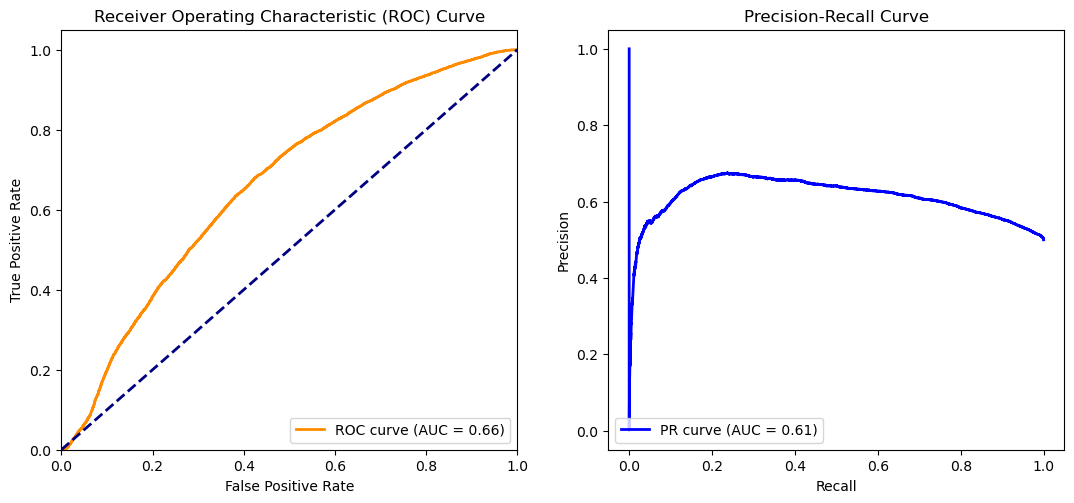

In [26]:
# Let's plot the AUC curve of the model.
plot_logistic_regression_evaluation(logistic_model_cv, X_test, Y_test)
plt.show()


In [27]:
# Predict the labels of the testing set
Y_pred_cv = logistic_model_cv.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_cv)

# Display the confusion matrix
class_names = ["Background", "Road"]
ConfusionMatrixDisplay.from_estimator(logistic_model_cv, X_test, Y_test, 
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=None).ax_.set_title("Confusion matrix")

# True positive
tp_cv   = conf_matrix[1, 1]
print("True positive: " + str(tp_cv))  

# True negative
tn_cv = conf_matrix[0, 0]
print("True negative: " + str(tn_cv))

# False positive
fp_cv = conf_matrix[0, 1]
print("False positive: " + str(fp_cv))

# False negative
fn_cv = conf_matrix[1, 0]
print("False negative: " + str(fn_cv))

#Use the confusion matrix to compute the accuracy, precision, recall and f1-score of the model
accuracy_cv = (tp_cv + tn_cv) / (tp_cv + tn_cv + fp_cv + fn_cv)
precision_cv = tp_cv / (tp_cv + fp_cv)
recall_cv = tp_cv / (tp_cv + fn_cv)
#f1_score = 2 * precision * recall / (precision + recall)
f1_score_cv = sklearn.metrics.f1_score(Y_test, Y_pred_cv)
print("Accuracy: " + str(round(accuracy_cv, 2)))
print("Precision: " + str(round(precision_cv, 2)))
print("Recall: " + str(round(recall_cv, 2)))
print("F1-score: " + str(round(f1_score_cv, 2)))


True positive: 5760
True negative: 5068
False positive: 3583
False negative: 2887
Accuracy: 0.63
Precision: 0.62
Recall: 0.67
F1-score: 0.64


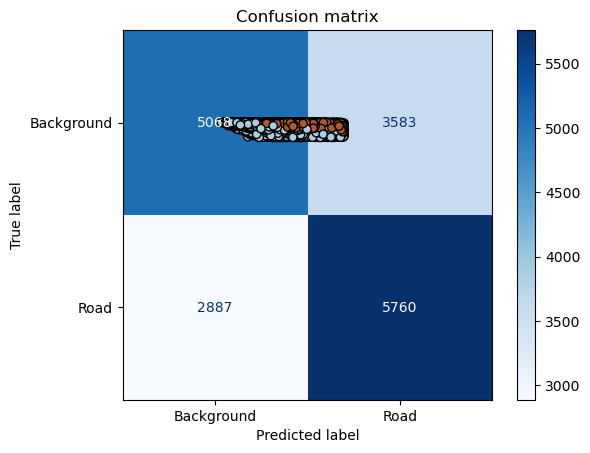

In [28]:
# Plot features using predictions to color datapoints
Y_train_pred_cv  = logistic_model_cv.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train_pred_cv, edgecolors="k", cmap=plt.cm.Paired)
plt.show()


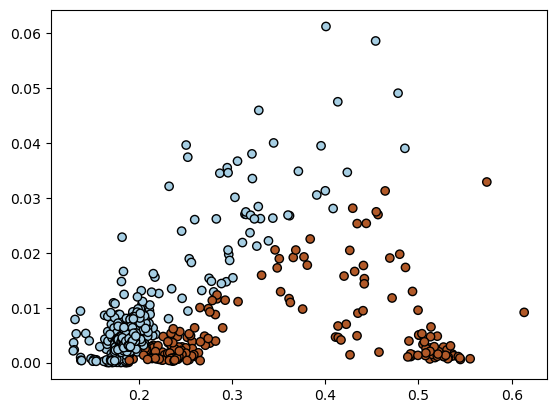

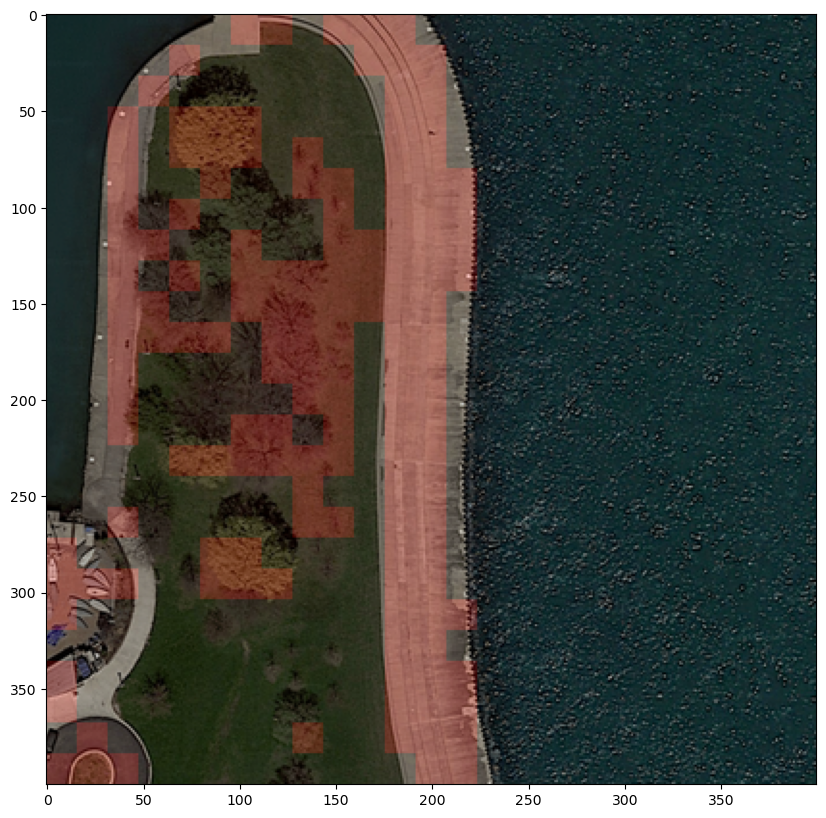

In [29]:
# Run prediction on the img_idx-th image
img_idx = 12
from helper import extract_img_features
Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi_cv = logistic_model_cv.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors="k", cmap=plt.cm.Paired)

# Display prediction as an image
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im_cv = label_to_img(w, h, patch_size, patch_size, Zi_cv)
cimg = concatenate_images(imgs[img_idx], predicted_im_cv)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img_cv = make_img_overlay(imgs[img_idx], predicted_im_cv)

plt.imshow(new_img_cv)
plt.show()

# Model 2: Random Forest

Let's try to improve the model by using a random forest classifier which captures non-linear relationships between features.


In [30]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf_model = RandomForestClassifier(class_weight="balanced", criterion="log_loss", n_estimators=100, max_depth=None, min_samples_split=5, min_samples_leaf=2)
rf_model.fit(X_train, Y_train)


RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       min_samples_leaf=2, min_samples_split=5)

In [32]:
# Compute the log loss of the model
Y_train_pred_proba_rf = rf_model.predict_proba(X_train)[:, 1]
Y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
log_loss_train_rf = log_loss(Y_train, Y_train_pred_proba_rf)
log_loss_test_rf = log_loss(Y_test, Y_test_pred_proba_rf)
print("The final training log loss is: " + str(round(log_loss_train_rf, 2)))
print("The final test log loss is: " + str(round(log_loss_test_rf, 2)))



The final training log loss is: 0.2
The final test log loss is: 0.48


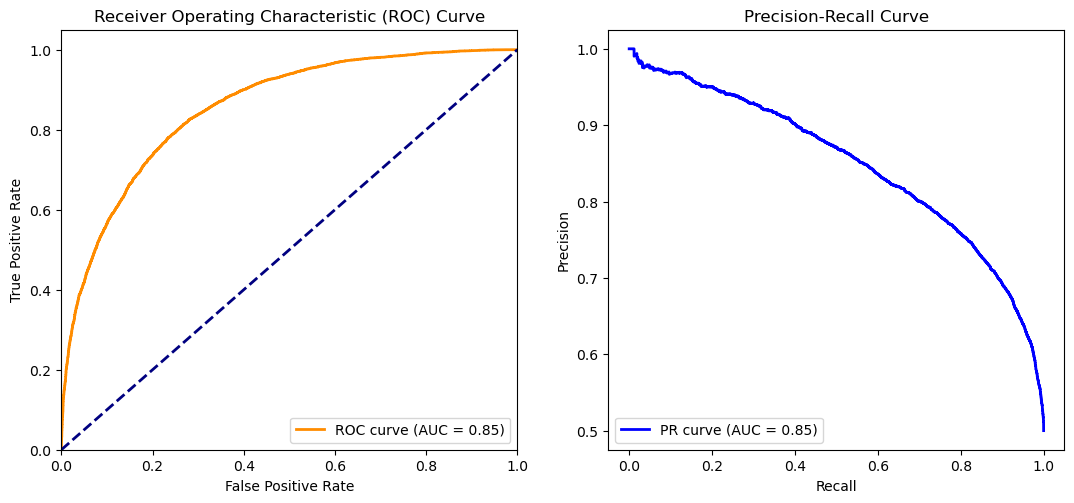

In [33]:
# Let's plot the AUC curve of the model.
plot_logistic_regression_evaluation(rf_model, X_test, Y_test)
plt.show()


In [34]:
optimal_threshold = 0.25
Y_pred_rf = (rf_model.predict_proba(X_test)[:, 1] > optimal_threshold).astype(int)

# Compute the confusion matrix
conf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)

# Display the confusion matrix
class_names = ["Background", "Road"]
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, Y_test, 
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=None).ax_.set_title("Confusion matrix")

# True positive
tp_rf = conf_matrix_rf[1, 1]
print("True positive: " + str(tp_rf))  

# True negative
tn_rf = conf_matrix_rf[0, 0]
print("True negative: " + str(tn_rf))

# False positive
fp_rf = conf_matrix_rf[0, 1]
print("False positive: " + str(fp_rf))

# False negative
fn_rf = conf_matrix_rf[1, 0]
print("False negative: " + str(fn_rf))

#Use the confusion matrix to compute the accuracy, precision, recall and f1-score of the model
accuracy_rf = (tp_rf + tn_rf) / (tp_rf + tn_rf + fp_rf + fn_rf)
precision_rf = tp_rf / (tp_rf + fp_rf)
recall_rf = tp_rf / (tp_rf + fn_rf)
f1_score_rf = sklearn.metrics.f1_score(Y_test, Y_pred_rf)
print("Accuracy: " + str(round(accuracy_rf, 2)))
print("Precision: " + str(round(precision_rf, 2)))
print("Recall: " + str(round(recall_rf, 2)))
print("F1-score: " + str(round(f1_score_rf, 2)))


True positive: 8336
True negative: 3548
False positive: 5103
False negative: 311
Accuracy: 0.69
Precision: 0.62
Recall: 0.96
F1-score: 0.75


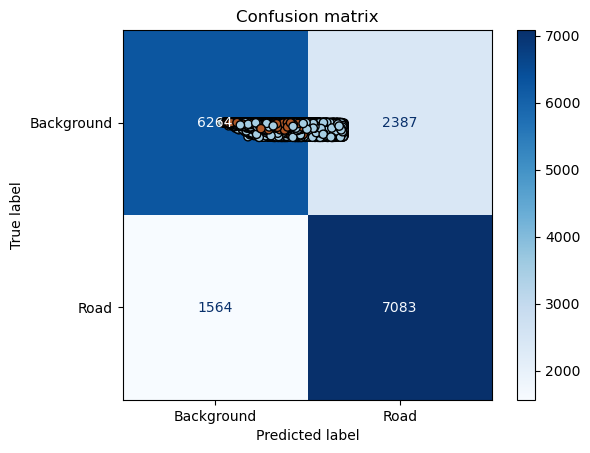

In [35]:
# Plot features using predictions to color datapoints
Y_train_pred_rf  = rf_model.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train_pred_rf, edgecolors="k", cmap=plt.cm.Paired)
plt.show()

(625, 4)
(625,)


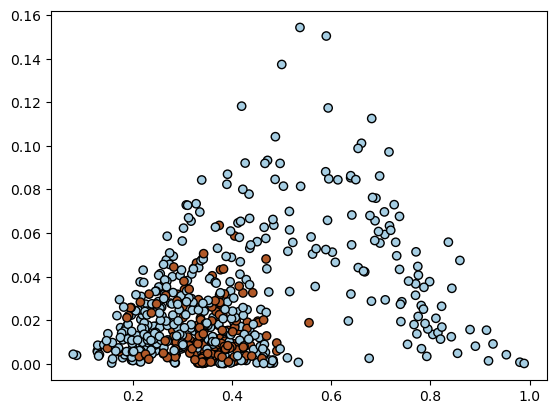

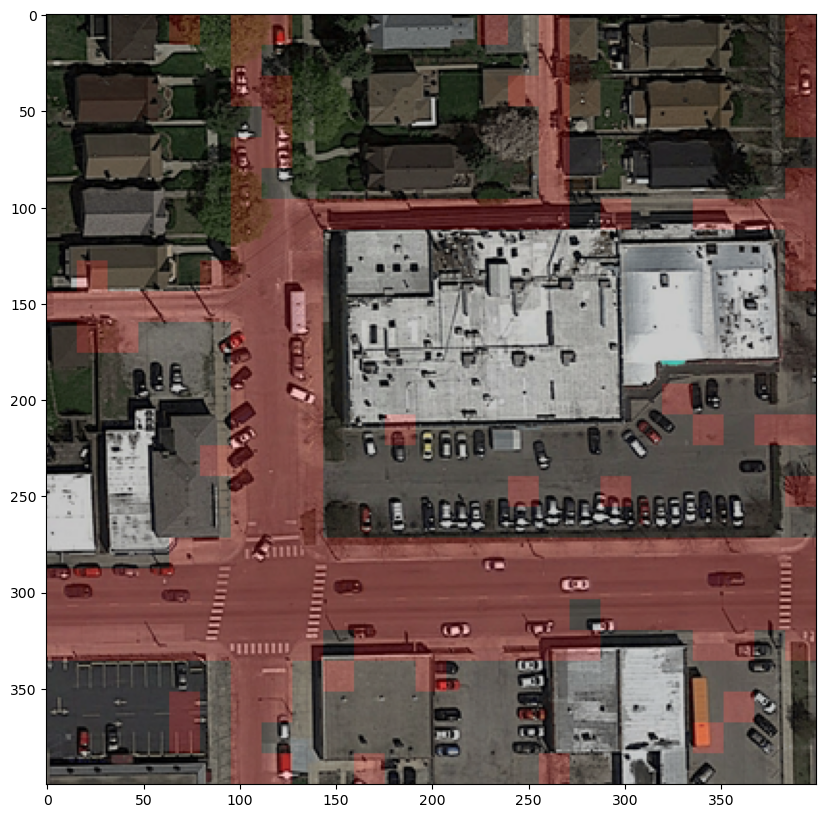

In [36]:
# Run prediction on the img_idx-th image
img_idx = 22
from helper import extract_img_features
Xi = extract_img_features(image_dir + files[img_idx], patch_size)
print(Xi.shape)
Zi_rf = rf_model.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi_rf, edgecolors="k", cmap=plt.cm.Paired)
print(Zi_rf.shape)

# Display prediction as an image
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im_rf = label_to_img(w, h, patch_size, patch_size, Zi_rf)
cimg = concatenate_images(imgs[img_idx], predicted_im_rf)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img_rf = make_img_overlay(imgs[img_idx], predicted_im_rf)

plt.imshow(new_img_rf)
plt.show()

# Model 3 : Convolutional Neural Network


In [37]:
#import CNN modules
import code
import urllib
from absl import app
from absl import flags
import tensorflow as tf
import tensorflow.python.platform
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc

# 
from cnn import *

/opt/anaconda3/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Loading training/images/satImage_001.png
Loading training/images/satImage_002.png
Loading training/images/satImage_003.png
Loading training/images/satImage_004.png
Loading training/images/satImage_005.png
Loading training/images/satImage_006.png
Loading training/images/satImage_007.png
Loading training/images/satImage_008.png
Loading training/images/satImage_009.png
Loading training/images/satImage_010.png
Loading training/images/satImage_011.png
Loading training/images/satImage_012.png
Loading training/images/satImage_013.png
Loading training/images/satImage_014.png
Loading training/images/satImage_015.png
Loading training/images/satImage_016.png
Loading training/images/satImage_017.png
Loading training/images/satImage_018.png
Loading training/images/satImage_019.png
Loading training/images/satImage_020.png
Loading training/images/satImage_021.png
Loading training/images/satImage_022.png
Loading training/images/satImage_023.png
Loading training/images/satImage_024.png
Loading training

/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6208 - auc: 0.6023 - loss: 0.7535 - val_accuracy: 0.7021 - val_auc: 0.6648 - val_loss: 0.5588
Epoch 2/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7267 - auc: 0.7174 - loss: 0.5466 - val_accuracy: 0.6943 - val_auc: 0.7251 - val_loss: 0.5894
Epoch 3/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7483 - auc: 0.7637 - loss: 0.5227 - val_accuracy: 0.7230 - val_auc: 0.8002 - val_loss: 0.6155
Epoch 4/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7596 - auc: 0.7955 - loss: 0.4993 - val_accuracy: 0.7486 - val_auc: 0.8245 - val_loss: 0.5281
Epoch 5/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7802 - auc: 0.8259 - loss: 0.4732 - val_accuracy: 0.7319 - val_auc: 0.8042 - val_loss: 0.5191
Epoch 6/100
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7756 - auc: 0.8252 - loss: 0.4776 - val_accuracy: 0.7491 - val_auc: 0.8175 - val_loss: 0.5726
Epoch 7/100
1620/1620 ━━━━━━

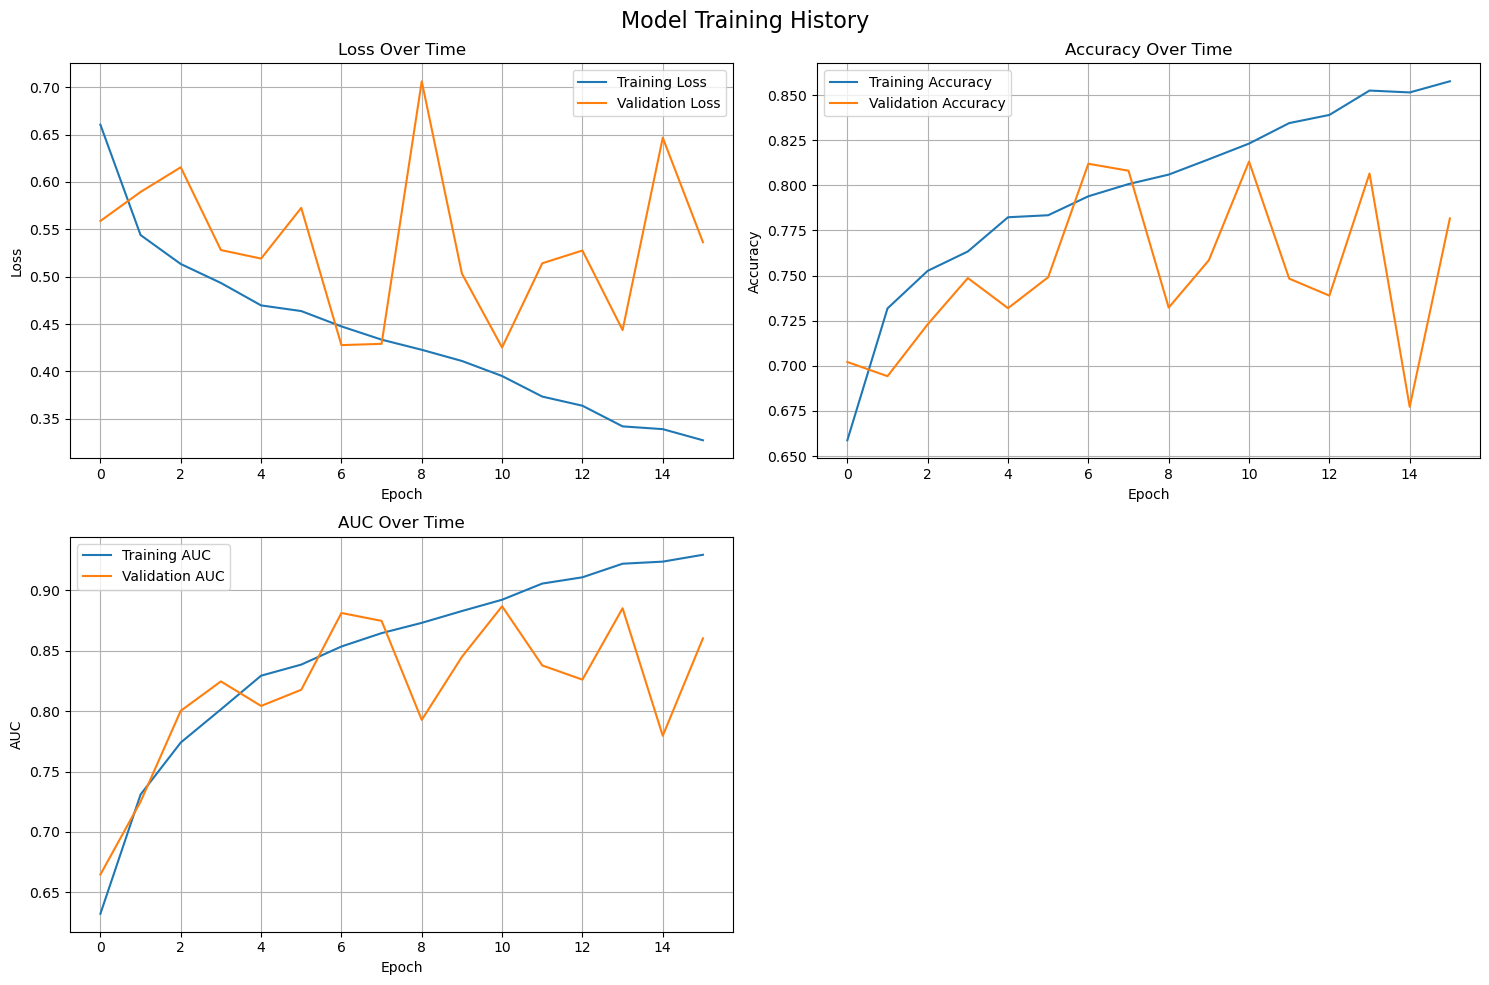

405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2024-11-27 19:45:17.715114: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


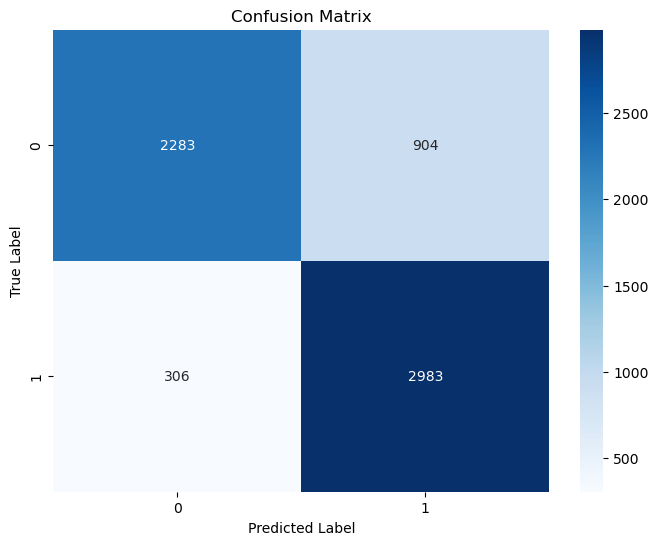

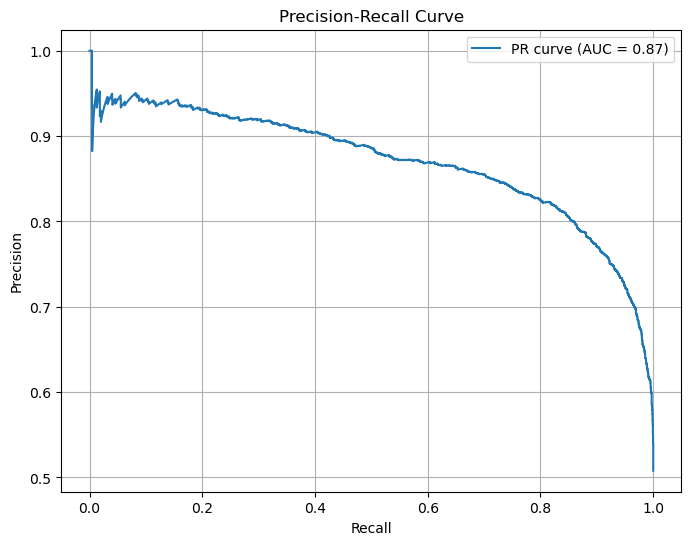

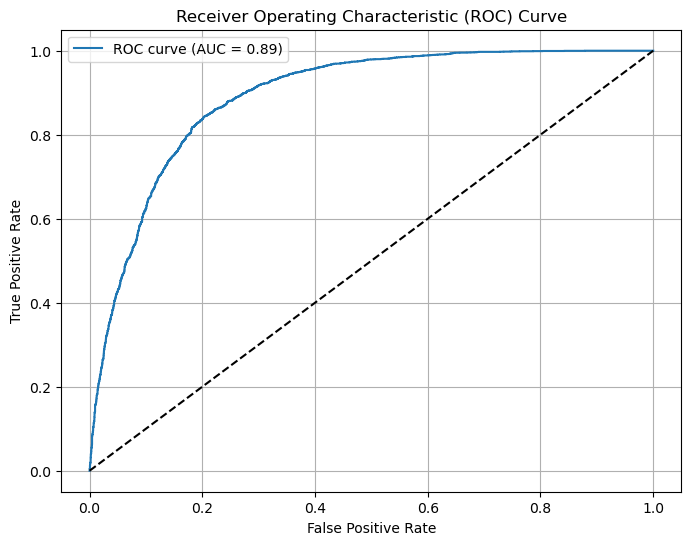


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      3187
           1       0.77      0.91      0.83      3289

    accuracy                           0.81      6476
   macro avg       0.82      0.81      0.81      6476
weighted avg       0.82      0.81      0.81      6476



In [38]:
# First, clear any existing TensorFlow session
import tensorflow as tf
tf.keras.backend.clear_session()

# Import your CNN module
from cnn import *

# Now train the model
model, history = train_model()

# Create directories if they don't exist
prediction_dir = "predictions_training/"
plots_dir = "plots"
for directory in [prediction_dir, plots_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)


In [39]:

# # Load and process test data
# test_dir = "test_set_images"
# test_filename = test_dir + "/test_" + str(1) + "/" + "test_" + str(1) + ".png"
# test_data = extract_output_data(test_filename, 1, IMG_PATCH_SIZE)
# test_data = test_data.astype(np.float32) / 255.0  # Normalize test data

# # Make predictions
# predictions = model.predict(test_data)

# # Reshape predictions back to image size
# predicted_mask = label_to_img_cnn(test_data.shape[1], test_data.shape[2], 
#                                 IMG_PATCH_SIZE, IMG_PATCH_SIZE, predictions)

# # Get true mask
# true_mask = extract_output_data(test_filename, 1, IMG_PATCH_SIZE)
# true_mask = true_mask.astype(np.float32) / 255.0
# print(test_data.shape, predicted_mask.shape, true_mask.shape, predictions.shape)

# # Visualize the prediction
# visualize_predictions(
#     test_data[0],  # Original image
#     true_mask[0],  # True mask
#     predicted_mask,  # Predicted mask
#     save_path=os.path.join(plots_dir, 'prediction_example.png')
# )

# # Plot training history
# plot_training_history(history)

Loading training/images/satImage_001.png
(625, 16, 16, 3)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(625, 2)
(400, 400)
(400, 400)


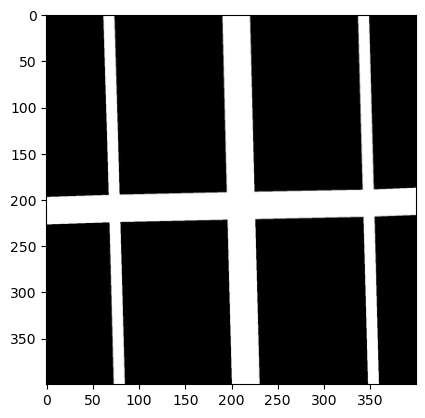

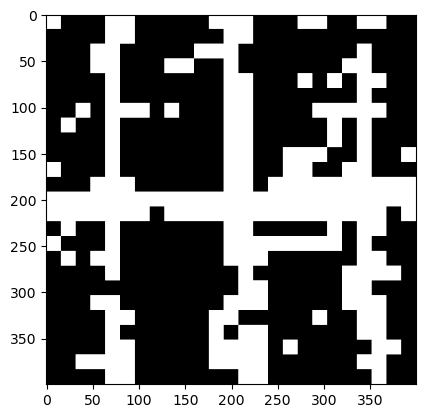

In [40]:
# Comparing with a true mask
img_idx = 12
Xi, ws, hs = extract_data("training/images/", 1, patch_size)
print(Xi.shape)
Zi_rf = model.predict(Xi)
print(Zi_rf.shape)

predicted_mask = label_to_img_cnn(ws[0], hs[0], IMG_PATCH_SIZE, IMG_PATCH_SIZE, Zi_rf)

count = 0

for i in predicted_mask:
    for j in i:
        if j == 1:
            count += 1

true_mask = mpimg.imread("training/groundtruth/satImage_001.png")
print(true_mask.shape)

print(predicted_mask.shape)

plt.imshow(true_mask, cmap="Greys_r")

plt.show()

plt.imshow(predicted_mask, cmap="Greys_r")

plt.show()
# plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi_rf, edgecolors="k", cmap=plt.cm.Paired)

# Display prediction as an image
# w = gt_imgs[img_idx].shape[0]
# h = gt_imgs[img_idx].shape[1]
# predicted_im_rf = label_to_img(w, h, patch_size, patch_size, Zi_rf)
# cimg = concatenate_images(imgs[img_idx], predicted_im_rf)
# fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
# plt.imshow(cimg, cmap="Greys_r")

# new_img_rf = make_img_overlay(imgs[img_idx], predicted_im_rf)

# plt.imshow(new_img_rf)
# plt.show()

In [ ]:
# Load and process test data
test_dir = "test_set_images"
test_filename = test_dir + "/test_" + str(1) + "/" + "test_" + str(1) + ".png"
test_data = extract_output_data(test_filename, IMG_PATCH_SIZE)
test_data = test_data.astype(np.float32) / 255.0  # Normalize test data

# Make predictions
predictions = model.predict(test_data)

# Reshape predictions back to image size
predicted_mask = label_to_img_cnn(608, 608, 
                                IMG_PATCH_SIZE, IMG_PATCH_SIZE, predictions)

print(predicted_mask.shape, test_data.shape, predictions.shape)

print(predictions)
print(predicted_mask)

count = 0

for i in predicted_mask:
    for j in i:
        if j == 0:
            count += 1

print(count)
## Still all of them are zeros

Loading test_set_images/test_1/test_1.png
(608, 608, 3) jgcuihdcihcoi
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(608, 608) (1444, 16, 16, 3) (1444, 2)
[[0.7694337  0.35686058]
 [0.77018297 0.35573465]
 [0.76907486 0.3572766 ]
 ...
 [0.7693372  0.35694394]
 [0.77072656 0.35613918]
 [0.7704651  0.35523784]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
369664


In [42]:
from mask_to_submission import *

image_filenames = [test_filename]